In [1]:
from osgeo import ogr, osr


In [ ]:
##wgs84转utm坐标系：

def trans(path, path_utm):  # path为矢量数据路径，path_utm为转换后的矢量数据路径
    # 1.打开矢量数据
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataSource = driver.Open(path, 1)  # 1表示可写模式
    layer = dataSource.GetLayer()

    # 获取原始坐标系
    src_srs = layer.GetSpatialRef()
    src_srs.ImportFromEPSG(4326)  # 确保源坐标系为EPSG:4326

    # 定义目标坐标系
    tgt_srs = osr.SpatialReference()
    # 内江市的UTM区域为32648（WGS 84 / UTM zone 48N）
    tgt_srs.ImportFromEPSG(32648)

    # 创建坐标转换对象
    transform = osr.CoordinateTransformation(src_srs, tgt_srs)

    # 创建新的数据源以存储转换后的数据
    new_driver = ogr.GetDriverByName("ESRI Shapefile")
    new_dataSource = new_driver.CreateDataSource(path_utm)
    new_layer = new_dataSource.CreateLayer("utm_layer",\
                                            tgt_srs,\
                                            layer.GetGeomType())

    # 复制字段
    for field_defn in layer.schema:
        new_layer.CreateField(field_defn)

    # 遍历原始图层的每个要素，转换坐标并写入新图层
    for feature in layer:
        geom = feature.GetGeometryRef()
        geom.Transform(transform)  # 转换坐标
        new_feature = ogr.Feature(new_layer.GetLayerDefn())
        new_feature.SetGeometry(geom)
        for i in range(layer.GetLayerDefn().GetFieldCount()):
            new_feature.SetField(layer.GetLayerDefn().GetFieldDefn(i).GetNameRef(), feature.GetField(i))
        new_layer.CreateFeature(new_feature)
        new_feature.Destroy()

    # 保存并关闭数据源
    dataSource = None
    new_dataSource = None





In [ ]:
# 调用函数
trans("E:\\开源\\HW3\\neijiang.shp", "E:\\开源\\HW3\\neijiang_utm.shp")

In [ ]:
##读取矢量要素，并返回字段数与要素数

def read(path):  # path为矢量数据路径

    # 打开矢量数据文件
    dataSource = ogr.Open(path)
    
    # 获取图层
    layer = dataSource.GetLayer()
    
    # 获取字段个数
    count_fields = layer.GetLayerDefn().GetFieldCount()
    
    # 获取要素个数
    count_features = layer.GetFeatureCount()
    
    # 关闭数据源
    dataSource = None
    
    return count_fields, count_features

# 调用
path = r"E:\\开源\\HW3\\neijiang.shp"
count_fields, count_features = read(path)
print(f"字段个数: {count_fields}, 要素个数: {count_features}")

字段个数: 8, 要素个数: 5


In [ ]:
##选择并输出要素

def vec_sel(path, path_out, field, field_value):
    # 打开矢量数据文件
    dataSource = ogr.Open(path)

    # 获取图层
    layer = dataSource.GetLayer()
    
    # 创建输出文件的图层
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if driver is None:
        print("驱动程序未找到")
        return
    outDataSource = driver.CreateDataSource(path_out)
    if outDataSource is None:
        print("创建输出文件失败")
        return

    # 复制图层的几何类型和字段
    outLayer = outDataSource.CreateLayer(layer.GetName(), layer.GetSpatialRef(), layer.GetGeomType())
    for i in range(layer.GetLayerDefn().GetFieldCount()):
        fieldDefn = layer.GetLayerDefn().GetFieldDefn(i)
        outLayer.CreateField(fieldDefn)

    # 选择特定字段值的要素并复制到输出文件
    for feature in layer:
        if feature.GetField(field) == field_value:
            featureDefn = outLayer.GetLayerDefn()
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetFrom(feature)
            outLayer.CreateFeature(outFeature)
            outFeature = None

    # 清理
    dataSource = None
    outDataSource = None




In [10]:
# 调用函数
vec_sel('E:\\开源\\HW3\\neijiang.shp', 'E:\\开源\\HW3\\weiyuan.shp', 'dt_name', 'weiyuanxian')

In [13]:
##选择并输出要素（多个）

def vec_sel(path, path_out, field, field_values):
    # 打开矢量数据文件
    dataSource = ogr.Open(path)
    if dataSource is None:
        print("无法打开文件")
        return
    
    # 获取图层
    layer = dataSource.GetLayer()
    
    # 创建输出文件的图层
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if driver is None:
        print("驱动程序未找到")
        return
    outDataSource = driver.CreateDataSource(path_out)
    if outDataSource is None:
        print("创建输出文件失败")
        return

    # 复制图层的几何类型和字段
    outLayer = outDataSource.CreateLayer(layer.GetName(), layer.GetSpatialRef(), layer.GetGeomType())
    for i in range(layer.GetLayerDefn().GetFieldCount()):
        fieldDefn = layer.GetLayerDefn().GetFieldDefn(i)
        outLayer.CreateField(fieldDefn)

    # 选择特定字段值的要素并复制到输出文件
    for feature in layer:
        if feature.GetField(field) in field_values:  # 检查字段值是否在列表中
            featureDefn = outLayer.GetLayerDefn()
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetFrom(feature)
            outLayer.CreateFeature(outFeature)
            outFeature = None

    # 清理
    dataSource = None
    outDataSource = None



In [14]:
# 调用函数
vec_sel('E:\\开源\\HW3\\neijiang.shp', 'E:\\开源\\HW3\\neijiang_sub.shp', 'dt_name', ['威远县', '东兴区', '资中县'])

In [2]:
##创建面矢量中心

def center_point(path, path_out):
    # 打开矢量数据文件
    dataSource = ogr.Open(path)
    if dataSource is None:
        print("无法打开文件")
        return

    # 获取图层
    layer = dataSource.GetLayer()
    
    # 创建输出文件的图层
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if driver is None:
        print("驱动程序未找到")
        return
    outDataSource = driver.CreateDataSource(path_out)
    if outDataSource is None:
        print("创建输出文件失败")
        return

    # 复制图层的几何类型和字段
    outLayer = outDataSource.CreateLayer(layer.GetName(), layer.GetSpatialRef(), ogr.wkbPoint)

    # 遍历每个面矢量，计算中心点，并创建点矢量
    for feature in layer:
        geometry = feature.GetGeometryRef()
        # 计算中心点
        center = geometry.Centroid()
        # 创建点要素
        outFeature = ogr.Feature(outLayer.GetLayerDefn())
        outFeature.SetGeometry(center)
        # 将点要素添加到输出图层
        outLayer.CreateFeature(outFeature)
        outFeature = None

    # 清理
    dataSource = None
    outDataSource = None



In [9]:

# 调用函数
center_point('E:\\开源\\HW3\\neijiang.shp', 'E:\\开源\\HW3\\nj_center_points.shp')

In [4]:
from osgeo import osr

In [ ]:
##创建新字段Area，并计算各行政区面积：

def add_area(path):
    # 打开数据源
    dataSource = ogr.Open(path, 1)  # 1表示可写模式

    # 获取图层
    layer = dataSource.GetLayer()

    # 创建面积字段
    field_def = ogr.FieldDefn("Area(km2)", ogr.OFTReal)  # 创建一个名为Area的字段，类型为实数
    layer.CreateField(field_def)  # 在图层中创建字段

    # 获取几何类型和空间参考
    geometry_type = layer.GetGeomType()
    spatial_ref = layer.GetSpatialRef()

    # 设置输出面积单位为平方千米
    # 首先需要将坐标系转换为投影坐标系，以便计算面积
    target_spatial_ref = osr.SpatialReference()
    target_spatial_ref.ImportFromEPSG(32648)  # 导入目标坐标系EPSG:32648

    # 创建坐标系转换对象
    coord_transform = osr.CoordinateTransformation(spatial_ref, target_spatial_ref)

    # 遍历图层中的每个要素
    for feature in layer:
        geometry = feature.GetGeometryRef()  # 获取几何对象
        geometry.Transform(coord_transform)  # 将几何对象转换为目标坐标系

        # 计算面积（单位：平方米）
        area_m2 = geometry.GetArea()

        # 将面积转换为平方千米
        area_km2 = area_m2 / 1e6  # 1平方千米 = 1e6平方米

        feature.SetField("Area(km2)", area_km2)  # 将计算的面积设置到新字段中
        layer.SetFeature(feature)  # 更新图层中的要素

    # 保存更新
    dataSource = None  # 关闭数据源



In [6]:
# 调用函数，计算面积用utm
path = "E:\\开源\\HW3\\neijiang_utm.shp"
add_area(path)

In [ ]:
# 读取字段，并绘制图表

def plot_area(path):
    import matplotlib.pyplot as plt
    dataSource = ogr.Open(path)
    layer = dataSource.GetLayer()

    dt_names = []
    areas_km2 = []

    # 遍历图层中的每个要素，收集dt_name和Area(km2)
    for feature in layer:
        dt_name = feature.GetField("dt_name")  # 假设dt_name是字段名
        area_km2 = feature.GetField("Area(km2)")
        dt_names.append(dt_name)
        areas_km2.append(area_km2)

    # 创建图表
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.bar(dt_names, areas_km2, width=0.5)  # 使用条形图显示数据
    ax.set_xlabel('dt_name')
    ax.set_ylabel('Area(km2)')
    ax.set_title('Area Distribution')
    plt.show()



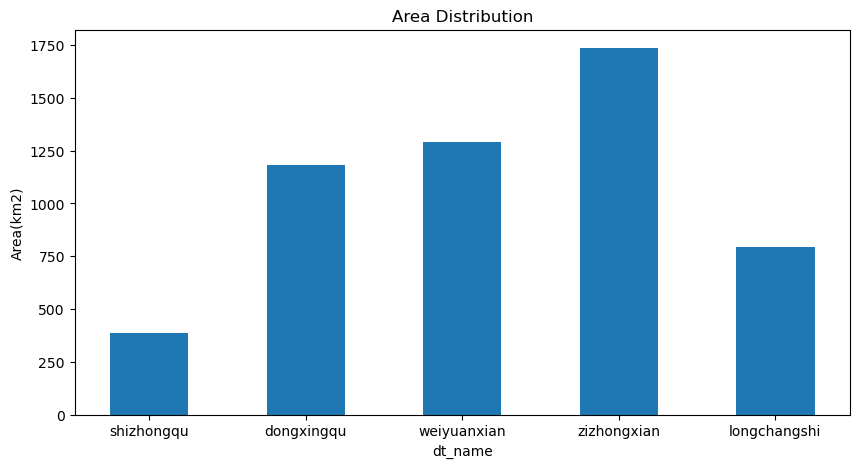

In [9]:
# 调用绘图函数
path = "E:\\开源\\HW3\\neijiang_utm.shp"
plot_area(path)

In [ ]:
##删除字段：

def delete(path, fields):
    # 打开数据源
    dataSource = ogr.Open(path, 1)  # 1表示以写入模式打开

    # 获取图层
    layer = dataSource.GetLayer()
    
    # 获取图层的字段数量
    fieldCount = layer.GetLayerDefn().GetFieldCount()
    
    # 遍历所有字段
    for i in range(fieldCount):
        fieldDefn = layer.GetLayerDefn().GetFieldDefn(i)
        fieldName = fieldDefn.GetName()
        
        # 检查字段名是否在需要删除的字段列表中
        if fieldName in fields:
            # 删除字段
            layer.DeleteField(i)
            
    # 保存更改并关闭数据源
    dataSource = None

In [10]:
# 矢量数据读入路径
path = 'E:\\开源\\HW3\\neijiang_utm.shp'
# 需要删除的字段
fields = ['Area(km2)']

# 调用函数
delete(path, fields)